## End to End PNNL Surrogate Model Training and Testing

Important parameters:

channel = 1 or 2 # do others later

gridsize = 128 or 512 

w = 10 # anything from 1 to 499 (simLen) is okay. 

latentDim = 16 

## Imports

In [1]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage, \
                                    pkl_save, pkl_load, create_1_channel_movie

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2, ConvDeconvFactor2

import numpy as np
from tqdm import tqdm
from copy import deepcopy
from glob import glob

import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimati
from matplotlib import animation, rc
from IPython.display import Image, Video
import matplotlib.pyplot as plt

## Settings

In [2]:
# data 
eval_only=False
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_end2end_plateau_train_ConvDeconvFactor2"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 2
gridsize = 128
dataDirec = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
preprocess = False # keep this as false until using the long runtime loader
testSplit = .2 # don't change this for now. 
AE = False
numWorkers = 2
physicsDim = 2 # inlet velocity and time sample

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = False  

# LIN parameters
hiddenLayers = [128,128]
activation = nn.ELU()

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 4
numSamplesToKeep = np.infty #if not debugging
latentDim = 1024
weight_decay = 0
use_sigmoid_output_layer = True
window_size = 150
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 500
stack = True
simVizIndex = 0 # sim in the test set to visualize
createStreamFcn = False
doJacobian = False
repeat = 3
skip_connection = False
patience = 3
act = nn.ELU() # AE parameter
norm_layer = [torch.nn.Identity][0]
if DEBUG:
    epochs = 10000
    numSamplesToKeep = 2 # 1 simulation
    
versionName = versionName + '_channel{}_gridsize{}_latentDim{}_window_size{}_weight_decay{}_batch_size{}'.format(channel,
                                gridsize, latentDim, window_size,weight_decay,bz)
versionName

'pnnl_end2end_plateau_train_ConvDeconvFactor2_GPUs23_channel2_gridsize128_latentDim1024_window_size150_weight_decay0_batch_size4'

## Select GPUs

In [3]:
!nvidia-smi

Sat Jan 23 15:43:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     12MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   17C    P8     9W / 250W |     12MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
2
0
TITAN Xp


In [7]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Sat Jan 23 15:43:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     12MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     12MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [8]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
# perm = np.random.permutation(numSims)
# testInds = perm[:idx]
# trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [9]:
testDataset = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=window_size)
trainDataset = CCSI_2D(trainSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=window_size)
len(testDataset), len(trainDataset)

(5000, 20000)

In [10]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True, 
                             num_workers=numWorkers, pin_memory=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz, num_workers=numWorkers, pin_memory=True)
len(trainDataLoader), len(testDataLoader)

(5000, 1250)

In [11]:
X,Y,p_x, p_y = next(iter(trainDataLoader))
X, Y, p_x, p_y = X.to(device), Y.to(device), p_x.to(device), p_y.to(device)
X.shape, Y.shape, p_x.shape, p_y.shape
print(X.shape,Y.shape,p_x.shape, p_y.shape)

torch.Size([4, 1, 128, 128]) torch.Size([4, 150, 1, 128, 128]) torch.Size([4, 2]) torch.Size([4, 150, 2])


## Model

In [12]:
AE_model = ConvDeconvFactor2(X, filters, latentDim, num_conv, repeat,
                          skip_connection, stack, conv_k=3, last_k=3, 
                          act=act, return_z=True, stream=createStreamFcn, device=device, 
                          use_sigmoid_output_layer=use_sigmoid_output_layer)


In [13]:
printNumModelParams(AE_model)

36 layers require gradients (unfrozen) out of 36 layers
146,681,347 parameters require gradients (unfrozen) out of 146,681,347 parameters


In [14]:
Xhat,z = AE_model(X,p_x)
Xhat.shape, z.shape

(torch.Size([4, 1, 128, 128]), torch.Size([4, 1024]))

In [15]:
model_to_load = os.path.join('/home/widemann1/surrogates4sims/exp_convDeconv_repeat/cps/',
'pnnl_ConvDeconvFactor2_GPUs0_channel2_gridsize128_latentDim1024_filters128_bz128_numConv4_jacobianFalse_sigmoid_outTrue_epochs1000_stackTrue_lr0.0001')

In [16]:
AE_model.load_state_dict(torch.load(model_to_load))

<All keys matched successfully>

In [17]:
if len(gpu_ids.split(',')) > 1:
    AE_model = nn.DataParallel(AE_model)

In [18]:
# LIN Model
class MLP(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1]))
            self.modules.append(self.activation)
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.inputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [19]:
LIN_model = MLP(z, hiddenLayerSizes=hiddenLayers, activation=activation)
LIN_model

MLP(
  (activation): ELU(alpha=1.0)
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=1024, bias=True)
  )
)

In [20]:
# surrogate class
class Surrogate(nn.Module):
    
    def __init__(self, window,
                 z_size, p_size,
                LIN, encoder, decoder):
        super(Surrogate, self).__init__()
        self.window = window
        self.z_size = z_size # this does not include the size of p
        self.p_size = p_size
        self.c_size = z_size + p_size # this does include the size of p
        self.LIN = LIN
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, U):
        
        return self.encoder(U)
        
    def decode(self, encoding):
        
        return self.decoder(encoding)
        
    def predict_next_w_encodings(self, encoding, p_y, window):
        '''
        use the LIN to predict the next w encodings for each 
        encoded U in the batch
        '''
            
        predicted_encodings = []
            
        # given a batch of encodings, advance each encoding window time steps.
        # save the result at each time step
        for i in range(window):
            encoding = self.LIN(encoding) + encoding # use LIN to predict delta in encoding
            # this was encoding[:,:,-self.p_size:] in 09_manta..., why the extra dimension?
            encoding[:,-self.p_size:] = p_y[:, i]
            predicted_encodings.append(encoding)
            
            
        return torch.stack(predicted_encodings)
    
    def forward(self, U, p_x, p_y, window = None):
        
        if window == None:
            window = self.window
        assert p_y.size(1) == window
            
        encoding = self.encode(U)
        encoding[:,-self.p_size:] = p_x # added this on 10/27/2020
        encoding_w = self.predict_next_w_encodings(encoding, p_y, window)
        # want to have this agree with U_y, which is [batch_size, window_size, channels, nx, ny]
        # right now, it's [window_size, batch_size, c_size], so transpose dimensions 0 and 1
        #print(encoding_w.shape)
        U = torch.stack([self.decode(encoding_i) for encoding_i in encoding_w])
        return U.transpose(0,1)
    

In [21]:
surrogate = Surrogate(window_size, latentDim - physicsDim, physicsDim, LIN_model, 
                      AE_model.module.encoder, AE_model.module.generator)

In [22]:
surrogate = surrogate.to(device)

In [23]:
encoding = surrogate.encode(X)
encoding.shape

torch.Size([4, 1024])

In [24]:
decoding = surrogate.decode(encoding)
decoding.shape

torch.Size([4, 1, 128, 128])

In [25]:
assert surrogate.c_size == latentDim
assert surrogate.p_size == physicsDim
assert encoding.shape[-1] == surrogate.c_size
assert decoding.shape == X.shape

In [26]:
Xhat = surrogate.forward(X, p_x, p_y)
Xhat.shape

torch.Size([4, 150, 1, 128, 128])

In [27]:
del surrogate, encoding, decoding, X, Y

surrogate = Surrogate(window_size, latentDim - physicsDim, physicsDim, LIN_model, 
                      AE_model.module.encoder, AE_model.module.generator).to(device)

if len(gpu_ids.split(',')) > 1:
    surrogate = nn.DataParallel(surrogate)

## Train

In [28]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(surrogate.parameters(),lr=max_lr,betas=(.5,.999), weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [29]:
def L2_relative_loss(pred, target):
    return torch.norm(pred - target)/torch.norm(target)


def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L = L2_relative_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L + Lj

In [30]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.to(device)
        p_x = p_x.to(device)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
            

        # zero the parameter gradients
        opt.zero_grad()

        U_hat = model(U_x, p_x, p_y)
        pl = 0
        ll = loss(U_hat, U_y, device)
        combined_loss = pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        batch_ploss = pl
        running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(U_hat, U_y)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            running_ploss = 0.0
            tensorboard_writer.flush()

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps

In [31]:
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.to(device) # only squeeze away the window dimension (because batch size = 1)
        p_x = p_x.to(device) # only squeeze away the window dimension (because batch size = 1)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
        
        perc = len(U_x)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            U_hat = model(U_x, p_x, p_y, window = window_size)

        # loss
        combined_loss = loss(U_hat, U_y, device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(U_hat, U_y)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
    tensorboard_writer.flush()
    
    return running_loss

In [32]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")
    
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

checkpoints directory already exists :)


In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

if not eval_only:
    for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times

        writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)

        surrogate.train()
        trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                       train_writer, surrogate,
                                                                       opt, p_loss, loss,
                                                                       rmse, lr_scheduler, 
                                                                       tensorboard_rate, device,
                                                                       tensorboard_recorder_step, total_steps)

        writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
        writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#         if trainLoss < bestLoss:
#             bestLoss = trainLoss
#             writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#             torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

        surrogate.eval()
        valLoss = validEpoch(testDataLoader, test_writer, surrogate, p_loss, loss, rmse, device, tensorboard_recorder_step)
        writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

        # checkpoint progress
        if valLoss < bestLoss:
            bestLoss = valLoss
            writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
            torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

        lr_scheduler.step(valLoss)

        if opt.param_groups[0]['lr'] < 5e-8:
            break
    writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---


In [34]:
# torch.save(surrogate.state_dict(), os.path.join(cps,versionName+"_final_not_necessarily_best"))

# Error metrics

In [32]:
surrogate.load_state_dict(torch.load(os.path.join(cps,versionName)))

<All keys matched successfully>

In [36]:
np.array(testSimFiles)[sorter],np.array(testSimFiles)

(array(['/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/005.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/010.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/014.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/017.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/018.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/028.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/034.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/036.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/038.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/048.pkl'],
       dtype='<U59'),
 array(['/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/005.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/014.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/010.pkl',
        '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsi

In [37]:
testDataset_fullSim = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=simLen-1)
first_frame_testDataset = torch.utils.data.Subset(testDataset_fullSim, range(0, len(testDataset), simLen))
simulation_testDataLoader = DataLoader(dataset=first_frame_testDataset, batch_size=2)

In [38]:
X,Y, p_x, p_y = next(iter(simulation_testDataLoader))
X.shape,Y.shape, p_x.shape, p_y.shape

(torch.Size([2, 1, 128, 128]),
 torch.Size([2, 499, 1, 128, 128]),
 torch.Size([2, 2]),
 torch.Size([2, 499, 2]))

In [39]:
surrogate.eval()
U_hats = []
Us = []
for i, sampleBatch in enumerate(simulation_testDataLoader, start=1):

    # gpu
    U_x, U_y, p_x, p_y = sampleBatch
    U_x = U_x.to(device)
    p_x = p_x.to(device)
    U_y = U_y.to(device)
    p_y = p_y.to(device)
    with torch.no_grad():
        Us.append(U_y.detach().cpu())
        
        U_hat = surrogate(U_x, p_x, p_y, window=simLen-1)
                    
        U_hats.append(U_hat.detach().cpu())
        
        
Real_U = torch.stack(Us)
#Real_X_img = convertSimToImage(Real_X)

Surr_U = torch.stack(U_hats)
#Surr_X_img = convertSimToImage(Surr_X)

In [40]:
for a,b in zip(Us,U_hats):
    rel_error = torch.norm(a - b)/torch.norm(a)
    writeMessage("Relative_Error: {:.4e}".format(rel_error),versionName)

Relative_Error: 5.8026e-01
Relative_Error: 5.5000e-01
Relative_Error: 5.7983e-01
Relative_Error: 6.4757e-01
Relative_Error: 6.3274e-01


In [41]:
rel_error = torch.norm(Real_U - Surr_U)/torch.norm(Real_U)
rel_error

tensor(0.6059)

In [43]:
Surr_U.shape

torch.Size([5, 2, 499, 1, 128, 128])

In [44]:
# save out sim 17
pkl_save(Surr_U.reshape((10,*Surr_U.shape[2:]))[4], '09_pnnl_nn_surrogate_test_sim_17')

In [71]:
# save out sim 38
pkl_save(Surr_U.reshape((10,*Surr_U.shape[2:]))[-3], '09_pnnl_nn_surrogate_test_sim_38')

In [53]:
x = pkl_load('triptych_sim_17_raw')
x=x.transpose(1,3)
x=x.transpose(1,2)
x.shape

torch.Size([499, 128, 384, 1])

In [52]:
!pwd

/net/10.57.1.2/vol/homes/bartoldson1/surrogates4sims


In [54]:
import imageio
imageio.mimwrite('output_filename.mp4', x , fps = 30)

In [35]:
sim = -1
rel_error_by_sim_and_frame = []
for row_real, row_surr in zip(Real_U,Surr_U):
    for batch_real, batch_surr in zip(row_real, row_surr):
        sim+=1
        rel_error_by_sim_and_frame.append([])
        for frame_real, frame_surr in zip(batch_real, batch_surr):
            assert frame_real.size()==torch.Size((1,128,128))
            rel_error_by_sim_and_frame[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))
print(sim)

9


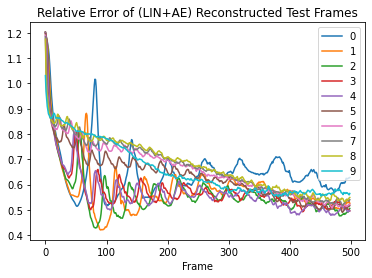

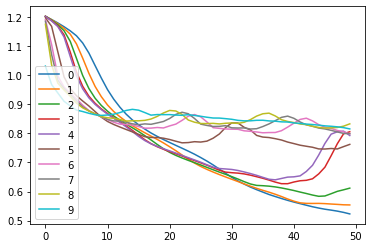

0.6259191

In [39]:

plt.plot(np.vstack(rel_error_by_sim_and_frame)[sorter].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.title('Relative Error of (LIN+AE) Reconstructed Test Frames')
plt.xlabel('Frame')
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[sorter][:,:50].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
np.vstack(rel_error_by_sim_and_frame).flatten().mean()

## Interfacial area

In [55]:
np.array(sims)[testInds]

array(['/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/005.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/014.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/010.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/018.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/017.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/028.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/036.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/038.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/048.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/034.pkl'],
      dtype='<U59')

In [56]:
[int(sims[idx][-7:-4]) for idx in testInds]

[5, 14, 10, 18, 17, 28, 36, 38, 48, 34]

In [57]:
sorter = np.argsort([int(sims[idx][-7:-4]) for idx in testInds])
sorter

array([0, 2, 1, 4, 3, 5, 9, 6, 7, 8])

In [58]:
np.array(testSimFiles)[sorter]

array(['/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/005.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/010.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/014.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/017.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/018.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/028.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/034.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/036.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/038.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/048.pkl'],
      dtype='<U59')

In [59]:
IAs = pkl_load('/data/ccsi/pnnl_liquid_inlet/interfacial_areas_{}.pkl'.format(gridsize))
IAs.shape

(50, 500)

In [60]:
test_sim_inds = sorted([np.nonzero(np.array(sorted(sims)) == x)[0][0] for x in testSimFiles])
np.array(sorted(sims))[test_sim_inds]

array(['/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/005.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/010.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/014.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/017.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/018.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/028.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/034.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/036.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/038.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/048.pkl'],
      dtype='<U59')

In [61]:
IAs = IAs[test_sim_inds]
IAs.shape

(10, 500)

In [62]:
Surr_U.reshape((10,*Surr_U.shape[2:])).shape

torch.Size([10, 499, 1, 128, 128])

In [63]:
from surrogates4sims.pnnlDatasets import computeInterfacialArea
gridsFile = '/data/ccsi/pnnl_liquid_inlet/grid_x_grid_y_{}.pkl'.format(gridsize)
grids = pkl_load(gridsFile)
grid_x = grids['grid_x']
grid_y = grids['grid_y']
levels = np.array([0.5])
def get_IA_for_sim(sim, last_n = 499):
    IA = []
    for Z in sim[-last_n:]:
        fig, ax = plt.subplots(figsize=(10,10))
        CS = ax.contour(grid_x,grid_y, Z.squeeze(), levels, origin='lower')
        plt.show()
        ia = computeInterfacialArea(grid_x,grid_y,Z.squeeze(),alpha=.5)
        print(ia)
        IA.append(ia)
        plt.close()
        print('-'*80)
    return IA

In [ ]:
predicted_frame_IAs = {}
predicted_frame_IAs[0] = get_IA_for_sim(Surr_U.reshape((10,*Surr_U.shape[2:]))[0])
plt.plot(predicted_frame_IAs[0])
plt.show()

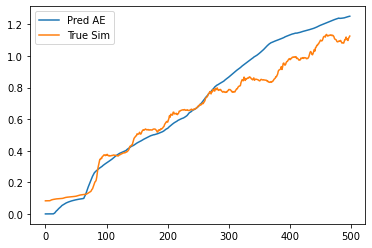

In [121]:
plt.plot(predicted_frame_IAs[0], label='Pred AE')
plt.plot(IAs[0][1:], label='True Sim')
plt.legend()
plt.show()

In [ ]:
for sim in range(1,10):
    predicted_frame_IAs[sim] = get_IA_for_sim(Surr_U.reshape((10,*Surr_U.shape[2:]))[sim])
    plt.plot(predicted_frame_IAs[sim], label='Pred AE')
    plt.plot(IAs[sim][1:], label='True Sim')
    plt.legend()
    plt.title('Simulation {}'.format(sim))
    plt.show()

In [8]:
actual_IAs = pkl_load('IAs_of_test_sims_and_bordering_train_IAs.pkl')

In [ ]:
for sim in range(1,10):
    predicted_frame_IAs[sim] = get_IA_for_sim(Surr_U.reshape((10,*Surr_U.shape[2:]))[sim])
    plt.plot(predicted_frame_IAs[sim], label='Pred AE')
    plt.plot(IAs[sim][1:], label='True Sim')
    plt.legend()
    plt.title('Simulation {}'.format(sim))
    plt.show()

In [67]:
actual_IAs = pkl_load('IAs_of_test_sims_and_bordering_train_IAs.pkl')

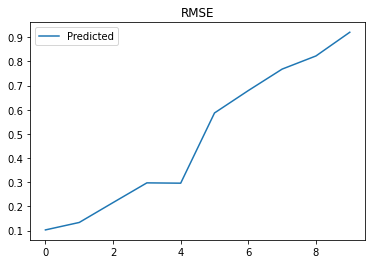

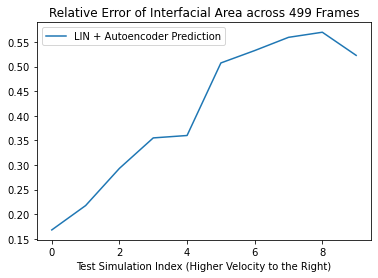

In [68]:
def RMSE(v1, v2):
    return np.mean((np.array(v1)-np.array(v2))**2)**0.5
def rel_error(v1, v2):
    assert np.min(np.array(v2))>=0
    return np.mean(np.abs(np.array(v1)-np.array(v2))/np.array(v2))

RMSE_pred = []
rel_error_pred = []
for sim in range(10):
    RMSE_pred.append(RMSE(predicted_frame_IAs[sorter[sim]], IAs[sim][1:]))
    rel_error_pred.append(rel_error(predicted_frame_IAs[sorter[sim]], IAs[sim][1:]))    
    
plt.plot(RMSE_pred, label='Predicted')
plt.legend()
plt.title('RMSE')
plt.show()
    
plt.plot(rel_error_pred, label='LIN + Autoencoder Prediction')
plt.legend()
plt.title("Relative Error of Interfacial Area across 499 Frames")
plt.xlabel('Test Simulation Index (Higher Velocity to the Right)')
plt.show()

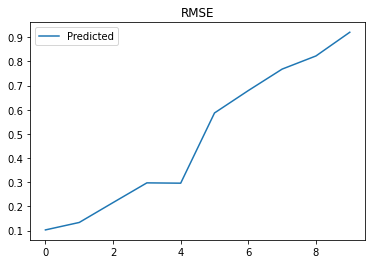

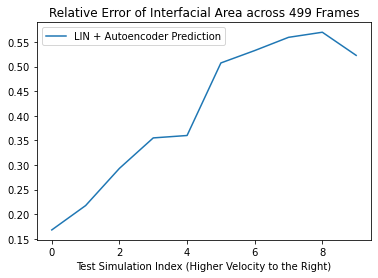

In [73]:
rel_error_by_frame={}
def RMSE(v1, v2):
    return np.mean((np.array(v1)-np.array(v2))**2)**0.5
def rel_error(v1, v2, sim):
    assert np.min(np.array(v2))>=0
    rel_error_by_frame[sim] = np.abs(np.array(v1)-np.array(v2))/np.array(v2)
    return np.mean(np.abs(np.array(v1)-np.array(v2))/np.array(v2))

RMSE_pred = []
rel_error_pred = []
for sim in range(10):
    RMSE_pred.append(RMSE(predicted_frame_IAs[sorter[sim]], IAs[sim][1:]))
    rel_error_pred.append(rel_error(predicted_frame_IAs[sorter[sim]], IAs[sim][1:],sim))    
    
plt.plot(RMSE_pred, label='Predicted')
plt.legend()
plt.title('RMSE')
plt.show()
    
plt.plot(rel_error_pred, label='LIN + Autoencoder Prediction')
plt.legend()
plt.title("Relative Error of Interfacial Area across 499 Frames")
plt.xlabel('Test Simulation Index (Higher Velocity to the Right)')
plt.show()

In [70]:
#pkl_save(rel_error_pred, 'rel_error_09_pnnl_nn_IA')
#pkl_save(rel_error_by_frame, 'rel_error_by_frame_09_pnnl_nn_IA')

In [175]:
AE_model.module.load_state_dict(torch.load(model_to_load))

<All keys matched successfully>

In [47]:
AE_model.eval()
AE_Us = []
for i, sampleBatch in enumerate(simulation_testDataLoader, start=1):

    # gpu
    U_x, U_y, p_x, p_y = sampleBatch
    U_x = U_x.to(device)
    p_x = p_x.to(device)
    U_y = U_y.to(device)
    p_y = p_y.to(device)
    with torch.no_grad():
        for sim_y, sim_p_y in zip(U_y,p_y):
            #use this chunking code if out of memory
#             def chunks(lst, n):
#                 for i in range(0, len(lst), n):
#                     yield lst[i:i + n]
                
            AE_Us.append((AE_model(sim_y, sim_p_y)[0]).cpu())
        
Real_AE_Vecs_U = torch.stack(AE_Us)
Real_AE_Vecs_U.shape

torch.Size([10, 499, 1, 128, 128])

9


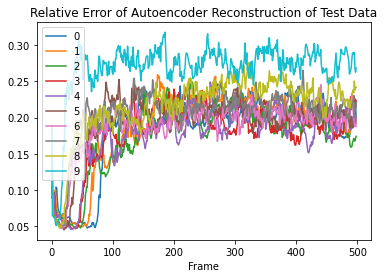

0.19657858

In [97]:
sim = -1
rel_error_by_sim_and_frame_AE_vecs = []
for row_real, row_surr in zip(Real_U,Real_AE_Vecs_U.reshape((5,2,499,1,128,128))):
    for batch_real, batch_surr in zip(row_real, row_surr):
        sim+=1
        rel_error_by_sim_and_frame_AE_vecs.append([])
        for frame_real, frame_surr in zip(batch_real, batch_surr):
            assert frame_real.size()==torch.Size((1,128,128))
            rel_error_by_sim_and_frame_AE_vecs[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))
print(sim)
plt.plot(np.vstack(rel_error_by_sim_and_frame_AE_vecs)[sorter].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.title("Relative Error of Autoencoder Reconstruction of Test Data")
plt.xlabel("Frame")
plt.show()
np.vstack(rel_error_by_sim_and_frame_AE_vecs).flatten().mean()

In [ ]:
AE_Vec_frame_IAs = {}
for sim in range(10):
    AE_Vec_frame_IAs[sim] = get_IA_for_sim(Real_AE_Vecs_U[sim])
    plt.plot(AE_Vec_frame_IAs[sim], label='Pred AE')
    plt.plot(IAs[sim][1:], label='True Sim')
    plt.legend()
    plt.title('Simulation {}'.format(sim))
    plt.show()

In [ ]:
AE_Vec_frame_IAs

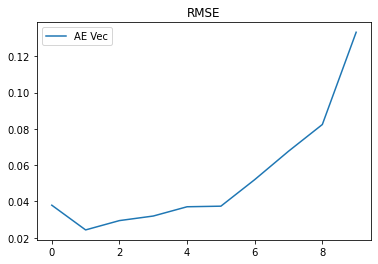

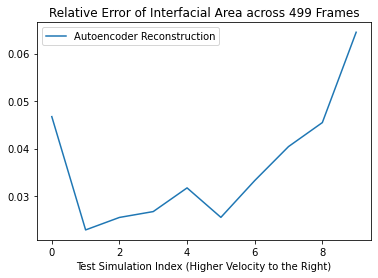

In [122]:
def RMSE(v1, v2):
    return np.mean((np.array(v1)-np.array(v2))**2)**0.5
def rel_error(v1, v2):
    assert np.min(np.array(v2))>=0
    return np.mean(np.abs(np.array(v1)-np.array(v2))/np.array(v2))

RMSE_AE_Vec = []
rel_error_AE_Vec  = []
for sim in range(10):
    RMSE_AE_Vec.append(RMSE(AE_Vec_frame_IAs[sorter[sim]], IAs[sim][1:]))
    rel_error_AE_Vec.append(rel_error(AE_Vec_frame_IAs[sorter[sim]], IAs[sim][1:]))
    
plt.plot(RMSE_AE_Vec, label = 'AE Vec')
plt.legend()
plt.title('RMSE')
plt.show()
    
plt.plot(rel_error_AE_Vec, label = 'Autoencoder Reconstruction')
plt.xlabel('Test Simulation Index (Higher Velocity to the Right)')
plt.legend()
plt.title("Relative Error of Interfacial Area across 499 Frames")
plt.show()

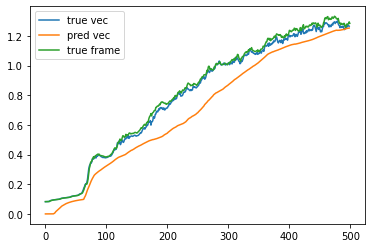

In [123]:
plt.plot(AE_Vec_frame_IAs[sorter[1]],label='true vec')
plt.plot(predicted_frame_IAs[sorter[1]],label='pred vec')
plt.plot(IAs[1],label='true frame')
plt.legend()
plt.show()

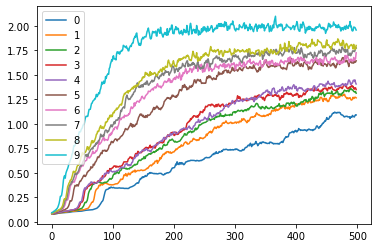

In [124]:
for i in range(10):
    plt.plot(AE_Vec_frame_IAs[sorter[i]],label=str(i))
plt.legend()

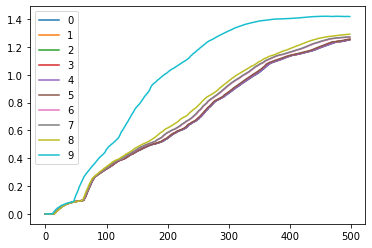

In [125]:
for i in range(10):
    plt.plot(predicted_frame_IAs[sorter[i]],label=str(i))
plt.legend()

In [176]:
AE_model.eval()
AE_train_Us = []
act_train_Us=[]
train_sim = CCSI_2D(trainSimFiles[1:41:4],doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=simLen-1)
first_frame_train = torch.utils.data.Subset(train_sim, range(0, 5000, simLen))
first_frame_trainDataLoader = DataLoader(dataset=first_frame_train, batch_size=2)
for i, sampleBatch in enumerate(first_frame_trainDataLoader, start=1):

    # gpu
    U_x, U_y, p_x, p_y = sampleBatch
    U_x = U_x.to(device)
    p_x = p_x.to(device)
    U_y = U_y.to(device)
    p_y = p_y.to(device)
    with torch.no_grad():
        for sim_x, sim_p_x, sim_y, sim_p_y in zip(U_x, p_x, U_y,p_y):
            #use this chunking code if out of memory
#             def chunks(lst, n):
#                 for i in range(0, len(lst), n):
#                     yield lst[i:i + n]
            act_train_Us.append(sim_y.detach().cpu())
            AE_train_Us.append((AE_model(sim_y, sim_p_y)[0]).cpu())

        
Real_AE_Vecs_U_train = torch.stack(AE_train_Us)
Act_U_train = torch.stack(act_train_Us)
Real_AE_Vecs_U_train.shape

torch.Size([10, 499, 1, 128, 128])

In [182]:
surrogate.load_state_dict(torch.load(os.path.join(cps,versionName)))
surrogate.eval()
U_hats_train =[]
U_train=[]
for i, sampleBatch in enumerate(first_frame_trainDataLoader, start=1):

    # gpu
    U_x, U_y, p_x, p_y = sampleBatch
    U_x = U_x.to(device)
    p_x = p_x.to(device)
    U_y = U_y.to(device)
    p_y = p_y.to(device)
    with torch.no_grad():
        U_hat = surrogate(U_x, p_x, p_y, window=simLen-1)
        U_hats_train.append(U_hat.detach().cpu())

        U_train.append(U_y.detach().cpu())
        
Surr_U_train = torch.stack(U_hats_train)
Surr_U_train = Surr_U_train.reshape((10,499,1,128,128))
Real_U_train = torch.stack(U_train)
Real_U_train = Real_U_train.reshape((10,499,1,128,128))

In [184]:
Act_U_train.shape, Surr_U_train.shape, Real_U_train.shape

(torch.Size([10, 499, 1, 128, 128]),
 torch.Size([10, 499, 1, 128, 128]),
 torch.Size([10, 499, 1, 128, 128]))

9


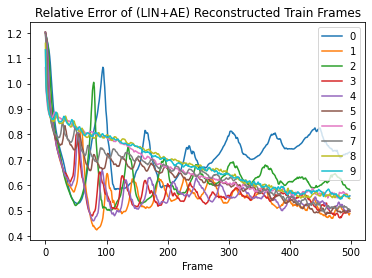

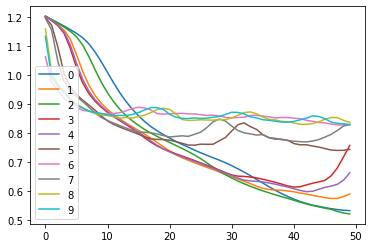

0.6401467

In [187]:
sim = -1
rel_error_by_sim_and_frame = []
for batch_real, batch_surr in zip(Real_U_train[sorter_train],Surr_U_train[sorter_train]):
    sim+=1
    rel_error_by_sim_and_frame.append([])
    for frame_real, frame_surr in zip(batch_real, batch_surr):
        assert frame_real.size()==torch.Size((1,128,128))
        rel_error_by_sim_and_frame[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))
print(sim)

plt.plot(np.vstack(rel_error_by_sim_and_frame)[sorter].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.title('Relative Error of (LIN+AE) Reconstructed Train Frames')
plt.xlabel('Frame')
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[sorter][:,:50].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
np.vstack(rel_error_by_sim_and_frame).flatten().mean()

In [ ]:
predicted_train_frame_IAs = {}
for sim in range(10):
    predicted_train_frame_IAs[sim] = get_IA_for_sim(Surr_U_train[sim])

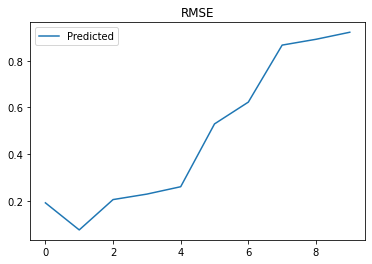

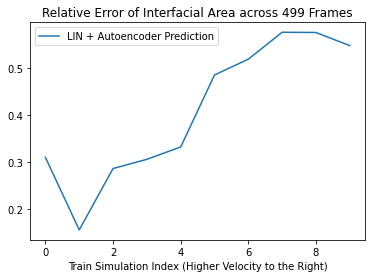

In [190]:
def RMSE(v1, v2):
    return np.mean((np.array(v1)-np.array(v2))**2)**0.5
def rel_error(v1, v2):
    assert np.min(np.array(v2))>=0
    return np.mean(np.abs(np.array(v1)-np.array(v2))/np.array(v2))

RMSE_pred = []
rel_error_pred = []
for sim in range(10):
    RMSE_pred.append(RMSE(predicted_train_frame_IAs[sorter_train[sim]], IAs_train[sim][1:]))
    rel_error_pred.append(rel_error(predicted_train_frame_IAs[sorter_train[sim]], IAs_train[sim][1:]))    
    
plt.plot(RMSE_pred, label='Predicted')
plt.legend()
plt.title('RMSE')
plt.show()
    
plt.plot(rel_error_pred, label='LIN + Autoencoder Prediction')
plt.legend()
plt.title("Relative Error of Interfacial Area across 499 Frames")
plt.xlabel('Train Simulation Index (Higher Velocity to the Right)')
plt.show()

9


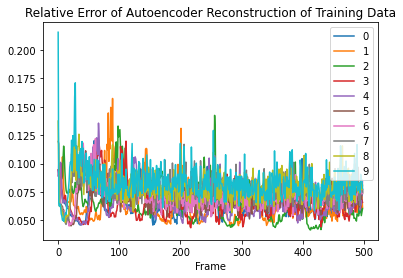

0.07161111

In [180]:
sim = -1
rel_error_by_sim_and_frame_AE_vecs_train = []
for batch_real, batch_surr in zip(Act_U_train,Real_AE_Vecs_U_train):
    sim+=1
    rel_error_by_sim_and_frame_AE_vecs_train.append([])
    for frame_real, frame_surr in zip(batch_real, batch_surr):
        assert frame_real.size()==torch.Size((1,128,128))
        rel_error_by_sim_and_frame_AE_vecs_train[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))
print(sim)
plt.plot(np.vstack(rel_error_by_sim_and_frame_AE_vecs_train).T)
plt.legend([i for i in range(10)])
plt.title("Relative Error of Autoencoder Reconstruction of Training Data")
plt.xlabel("Frame")
plt.show()
np.vstack(rel_error_by_sim_and_frame_AE_vecs_train).flatten().mean()

In [129]:
train_AE_Vec_IAs = {}
for i in range(10):
    train_AE_Vec_IAs[i] = get_IA_for_sim(Real_AE_Vecs_U_train[i])

train_AE_Vec_IAs = pkl_load('random_train_IAs')

In [130]:
train_AE_Vec_IAs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
train_act_IAs = {}
for i in range(10):
    train_act_IAs[i] = get_IA_for_sim(Act_U_train[i])

In [144]:
sample_train_sims = [np.nonzero(np.array(sorted(sims)) == x)[0][0] for x in sorted(trainSimFiles[1:41:4])]
sample_train_sims

[0, 5, 12, 14, 15, 26, 29, 39, 41, 45]

In [145]:
sorter_train = np.argsort([int(x[-7:-4]) for x in trainSimFiles[1:41:4]])
sorter_train

array([2, 1, 3, 4, 0, 5, 6, 7, 8, 9])

In [146]:
np.array(trainSimFiles[1:41:4])[sorter_train]

array(['/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/001.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/006.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/013.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/015.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/016.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/027.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/030.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/040.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/042.pkl',
       '/data/ccsi/pnnl_liquid_inlet/channel_2/gridsize_128/046.pkl'],
      dtype='<U59')

In [147]:
IAs_train = pkl_load('/data/ccsi/pnnl_liquid_inlet/interfacial_areas_{}.pkl'.format(gridsize))
IAs_train = IAs_train[np.array(sample_train_sims)]

In [151]:
for i in range(10):
    print(np.allclose(train_act_IAs[sorter_train[i]], IAs_train[i][1:]))

True
True
True
True
True
True
True
True
True
True


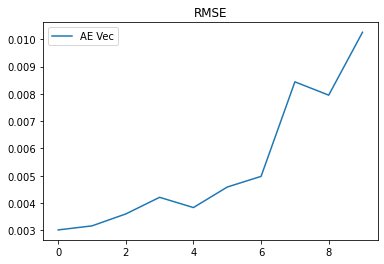

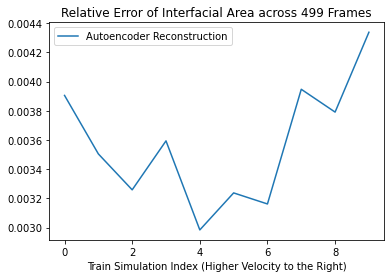

In [153]:
def RMSE(v1, v2):
    return np.mean((np.array(v1)-np.array(v2))**2)**0.5
def rel_error(v1, v2):
    assert np.min(np.array(v2))>=0
    return np.mean(np.abs(np.array(v1)-np.array(v2))/np.array(v2))


RMSE_AE_Vec = []
rel_error_AE_Vec  = []
for sim in range(10):
    RMSE_AE_Vec.append(RMSE(train_AE_Vec_IAs[sorter_train[sim]], IAs_train[sim][1:]))
    rel_error_AE_Vec.append(rel_error(train_AE_Vec_IAs[sorter_train[sim]], IAs_train[sim][1:]))
    
plt.plot(RMSE_AE_Vec, label = 'AE Vec')
plt.legend()
plt.title('RMSE')
plt.show()
    
plt.plot(rel_error_AE_Vec, label = 'Autoencoder Reconstruction')
plt.legend()
plt.title("Relative Error of Interfacial Area across 499 Frames")
plt.xlabel('Train Simulation Index (Higher Velocity to the Right)')
plt.show()

In [74]:
p_y.shape

torch.Size([2, 499, 2])

# Movie

In [191]:
def create_1_channel_movie(im,outfile='sim.mp4',title='surrogate            simulation'):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    cmap = plt.cm.ocean
    img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(im[i].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'])

In [192]:
Real_U_img = [torch.rot90(convertSimToImage(r),1,dims=[2,3]) for row in Real_U for r in row]
Surr_U_img = [torch.rot90(convertSimToImage(s),1,dims=[2,3]) for row in Surr_U for s in row]

Xrgb = torch.cat([torch.stack(Surr_U_img), torch.stack(Real_U_img)], dim=4)
Xrgb.shape

torch.Size([10, 499, 1, 128, 256])

MovieWriter stderr:
[gif @ 0x5623e8e83f00] GIF muxer supports only a single video GIF stream.
Could not write header for output file #0 (incorrect codec parameters ?): Invalid argument
Error initializing output stream 0:0 -- 



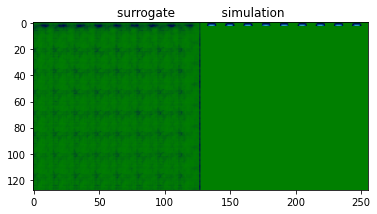

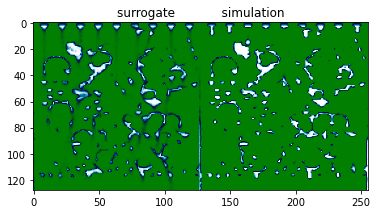

In [193]:
try:
    gif = True
    outGif = '{}.gif'.format(versionName)
    create_1_channel_movie(Xrgb[1].detach().numpy(),outfile=outGif)
except:
    gif = False
    outGif = '{}.mp4'.format(versionName)
    create_1_channel_movie(Xrgb[1].detach().numpy(),outfile=outGif)

In [194]:
Video(outGif)

In [47]:
# check results with train data
trainDataset_fullSim = CCSI_2D(trainSimFiles,doPreprocess=preprocess,
                              numToKeep=numSamplesToKeep,channel=channel,AE=AE, w=simLen-1)
first_frame_trainDataset = torch.utils.data.Subset(trainDataset_fullSim, range(0, len(trainDataset), simLen))
simulation_trainDataLoader = DataLoader(dataset=first_frame_trainDataset, batch_size=2)
X,Y, p_x, p_y = next(iter(simulation_testDataLoader))
X.shape,Y.shape, p_x.shape, p_y.shape

(torch.Size([2, 1, 128, 128]),
 torch.Size([2, 499, 1, 128, 128]),
 torch.Size([2, 2]),
 torch.Size([2, 499, 2]))

In [48]:
surrogate.eval()
U_hats = []
Us = []
for i, sampleBatch in enumerate(simulation_trainDataLoader, start=1):

    # gpu
    U_x, U_y, p_x, p_y = sampleBatch
    U_x = U_x.to(device)
    p_x = p_x.to(device)
    U_y = U_y.to(device)
    p_y = p_y.to(device)
    with torch.no_grad():
        Us.append(U_y.detach().cpu())
        
        U_hat = surrogate(U_x, p_x, p_y, window=simLen-1)
                    
        U_hats.append(U_hat.detach().cpu())
        
        
Real_U = torch.stack(Us)
#Real_X_img = convertSimToImage(Real_X)

Surr_U = torch.stack(U_hats)
#Surr_X_img = convertSimToImage(Surr_X)

sim = -1
rel_error_by_sim_and_frame = []
for row_real, row_surr in zip(Real_U,Surr_U):
    for batch_real, batch_surr in zip(row_real, row_surr):
        sim+=1
        rel_error_by_sim_and_frame.append([])
        for frame_real, frame_surr in zip(batch_real, batch_surr):
            assert frame_real.size()==torch.Size((1,128,128))
            rel_error_by_sim_and_frame[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))
print(sim)

39


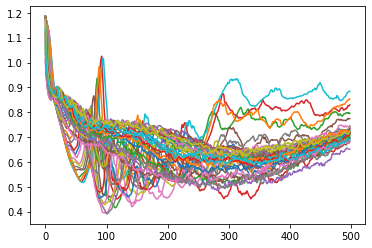

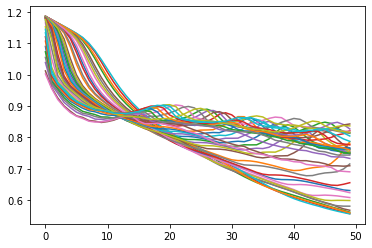

In [49]:
plt.plot(np.vstack(rel_error_by_sim_and_frame).T)
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[:,:50].T)
plt.show()